In [138]:
# #pip install contractions
# #!pip install -U pip setuptools wheel
# !pip install -U spacy
# !python -m spacy download en_core_web_sm
# #!pip install bertopic
# #!pip install yellowbrick
# #!pip install distance

#https://towardsdatascience.com/how-to-cluster-similar-sentences-using-tf-idf-and-graph-partitioning-in-python-5fb70627a4e0
    
#https://stackoverflow.com/questions/71635040/get-jaccard-similarity-by-comparing-all-rows-in-a-pandas-dataframe-while-keeping
    
    

In [139]:
import pandas as pd
import numpy as np
import unicodedata
import re
import contractions
import string
#import distance

#vis
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns 
from tqdm import tnrange

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AffinityPropagation

from sklearn import preprocessing
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import adjusted_rand_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
sns.set() 

#spacy
import spacy
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nlp = spacy.load("en_core_web_sm")
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer 
# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()
import textwrap
stops = stopwords.words('english')
stops += ['use', 'using', 'used', 'part']

#from bertopic import BERTopic

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package 

In [140]:
def load_data():   #load the data 
    df_all = pd.read_csv('Created_Cases - databricks.csv')
    # Take a subset
    return df_all.loc[:, ["Case title"]]
data = load_data()
data.rename(
    columns=({ 'Case title': 'Case_title', 'Session Id': 'Session_Id','Date Time':'Date_Time','Email Id':'Email_Id'}), 
    inplace=True
)
data.head()

,Case_title
0,genie
1,genie
2,jproperties library installation issue
3,Union with Null
4,Spark ReadStream fails to infer schema


# How to clean text data?
Cleaning data is an important step (if not the most important part) when working with text. There are standard practices in place that one follows when dealing with such tasks. We will undertake following steps to process titles and subtitles:

remove punctuation marks and other symbols
remove stop words and digits
lemmatise words
We will use a mixture of regular expressions and nltk library to remove punctuation marks, symbols, stop words and digits.

In [141]:
import re
data['Case_title'] = [re.findall(r'\w+', i.lower()) for i in data['Case_title'].fillna('NONE')]

In [142]:
new_titles_sub = []
for title_sub in data['Case_title']:
    new_title_sub = []
    for w_title in title_sub:
        if w_title not in stops and not w_title.isdigit():
            new_title_sub.append(w_title)
    
    new_titles_sub.append(new_title_sub) 
    
data['new_title_subtitle'] = new_titles_sub
data['Case_title'] = [' '.join(i) for i in data['Case_title']]

In [143]:
data.head()

,Case_title,new_title_subtitle
0,genie,[genie]
1,genie,[genie]
2,jproperties library installation issue,"[jproperties, library, installation, issue]"
3,union with null,"[union, null]"
4,spark readstream fails to infer schema,"[spark, readstream, fails, infer, schema]"


# LEMMATISATION

In [144]:
nltk.download('wordnet')
nltk.download('words')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
new_titles_sub = []
for title_sub in data['new_title_subtitle']:
    new_title_sub = []
    for w_title in title_sub:
        new_title_sub.append(wordnet_lemmatizer.lemmatize(w_title, pos="v"))
    new_titles_sub.append(new_title_sub) 
    
data['new_title_subtitle'] = new_titles_sub
data['new_title_subtitle'] = ['  '.join(i) for i in data['new_title_subtitle']]

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [145]:
data.head()

,Case_title,new_title_subtitle
0,genie,genie
1,genie,genie
2,jproperties library installation issue,jproperties library installation issue
3,union with null,union null
4,spark readstream fails to infer schema,spark readstream fail infer schema


In [146]:
#df1 = df1[['Case_title','new_title_subtitle']]

In [147]:
#df1.set_index('Case_title', inplace=True)

In [148]:
#df1.head()

In [150]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0)
tfidf_matrices = []
data_sets = []
for source in data:
    source_data = data.drop_duplicates(subset=['Case_title','new_title_subtitle'])
    data_sets.append(source_data['new_title_subtitle'])
    tfidf_matrices.append(tf.fit_transform(
source_data['new_title_subtitle']))


In [151]:
data_sets

[0                                                   genie
 2               jproperties  library  installation  issue
 3                                             union  null
 4                  spark  readstream  fail  infer  schema
 5                                  genie  access  request
                               ...                        
 7604    genie  j  j  job  fail  synapse  intermittent ...
 7605    try  connect  microstrategy  iserver  db  conn...
 7606                  databricks  shard  upgrade  support
 7607                               cluster  crash  weekly
 7608    security  alert  connectivity  aws  account  o...
 Name: new_title_subtitle, Length: 6141, dtype: object,
 0                                                   genie
 2               jproperties  library  installation  issue
 3                                             union  null
 4                  spark  readstream  fail  infer  schema
 5                                  genie  access  request


In [152]:
from sklearn.metrics.pairwise import linear_kernel
matrix_with_cos_sim = []
for m in tfidf_matrices:
    matrix_with_cos_sim.append(linear_kernel(m, m))

In [153]:
import numpy as np
from tqdm import tnrange
top_n_sentences = []
for cs, t in zip(matrix_with_cos_sim, data_sets):
    no_dups = np.array(t)
    i = 0
    top_frame = []
    for c, z in zip(cs, tnrange(len(cs))):
        # Create vector of titles
        start_name = pd.Series([no_dups[i]]*15) 
        # Index of top 15 similar titles
        ix_top_n = np.argsort(-c)[0:15]
        cos_sim = pd.Series(c[ix_top_n])
        names = pd.Series(no_dups[ix_top_n])
        i +=1
        top_frame.append(pd.DataFrame([start_name, names, cos_sim]).transpose())
    
    top_frame = pd.concat(top_frame)
    top_frame.columns = ['title1', 'title2', 'cos_sim']
    # Remove the similarities for the same sentences
    top_frame['is_same'] = [bool(i==j) for i, j in zip(top_frame['title1'], top_frame['title2'])]
    top_frame = top_frame[top_frame['is_same'] != True]
        
    top_n_sentences.append(top_frame)


/var/folders/7q/zq0k80m94v5408fgfvkddv880000gp/T/ipykernel_55646/3912787995.py:8: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for c, z in zip(cs, tnrange(len(cs))):


  0%|          | 0/6141 [00:00<?, ?it/s]

/var/folders/7q/zq0k80m94v5408fgfvkddv880000gp/T/ipykernel_55646/3912787995.py:8: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for c, z in zip(cs, tnrange(len(cs))):


  0%|          | 0/6141 [00:00<?, ?it/s]

In [154]:
top_frame

,title1,title2,cos_sim,is_same
1,jproperties library installation issue,genie library installation issue,0.561559,False
2,jproperties library installation issue,arr library installation issue,0.561126,False
3,jproperties library installation issue,intermittent library installation issue,0.548303,False
4,jproperties library installation issue,package installation issue,0.29773,False
5,jproperties library installation issue,databricks library installation fail,0.25917,False
...,...,...,...,...
10,security alert connectivity aws account o...,security feature,0.102929,False
11,security alert connectivity aws account o...,set new connectivity aws s3 require new ...,0.102533,False
12,security alert connectivity aws account o...,private link enablement new aws account,0.101306,False
13,security alert connectivity aws account o...,stting new connectivity aws s3 require n...,0.100678,False


In [155]:
df2 = pd.DataFrame(top_n_sentences[0], columns = ['title1','title2','cos_sim','is_same'])
df2

,title1,title2,cos_sim,is_same
1,jproperties library installation issue,genie library installation issue,0.561559,False
2,jproperties library installation issue,arr library installation issue,0.561126,False
3,jproperties library installation issue,intermittent library installation issue,0.548303,False
4,jproperties library installation issue,package installation issue,0.29773,False
5,jproperties library installation issue,databricks library installation fail,0.25917,False
...,...,...,...,...
10,security alert connectivity aws account o...,security feature,0.102929,False
11,security alert connectivity aws account o...,set new connectivity aws s3 require new ...,0.102533,False
12,security alert connectivity aws account o...,private link enablement new aws account,0.101306,False
13,security alert connectivity aws account o...,stting new connectivity aws s3 require n...,0.100678,False


In [156]:
df2.to_csv('similar-sent-1.csv')

In [157]:
df3 = pd.DataFrame(top_n_sentences[1], columns = ['title1','title2','cos_sim','is_same'])
df3

,title1,title2,cos_sim,is_same
1,jproperties library installation issue,genie library installation issue,0.561559,False
2,jproperties library installation issue,arr library installation issue,0.561126,False
3,jproperties library installation issue,intermittent library installation issue,0.548303,False
4,jproperties library installation issue,package installation issue,0.29773,False
5,jproperties library installation issue,databricks library installation fail,0.25917,False
...,...,...,...,...
10,security alert connectivity aws account o...,security feature,0.102929,False
11,security alert connectivity aws account o...,set new connectivity aws s3 require new ...,0.102533,False
12,security alert connectivity aws account o...,private link enablement new aws account,0.101306,False
13,security alert connectivity aws account o...,stting new connectivity aws s3 require n...,0.100678,False


In [158]:
df3.to_csv('similar-sent-2.csv')

In [159]:
# We start by defining the structure of the graph
top_frame = top_n_sentences[0] #TDS articles
edges = list(zip(top_frame['title1'], top_frame['title2']))
weighted_edges = list(zip(top_frame['title1'], top_frame['title2'], top_frame['cos_sim']))
nodes = list(set(top_frame['title1']).union(set(top_frame['title2'])))

In [160]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
G.add_weighted_edges_from(weighted_edges)

In [161]:
#!pip install python-louvain
import community
partition = community.best_partition(G)
modularity = community.modularity(partition, G)


In [162]:
#pip install --upgrade scipy networkx

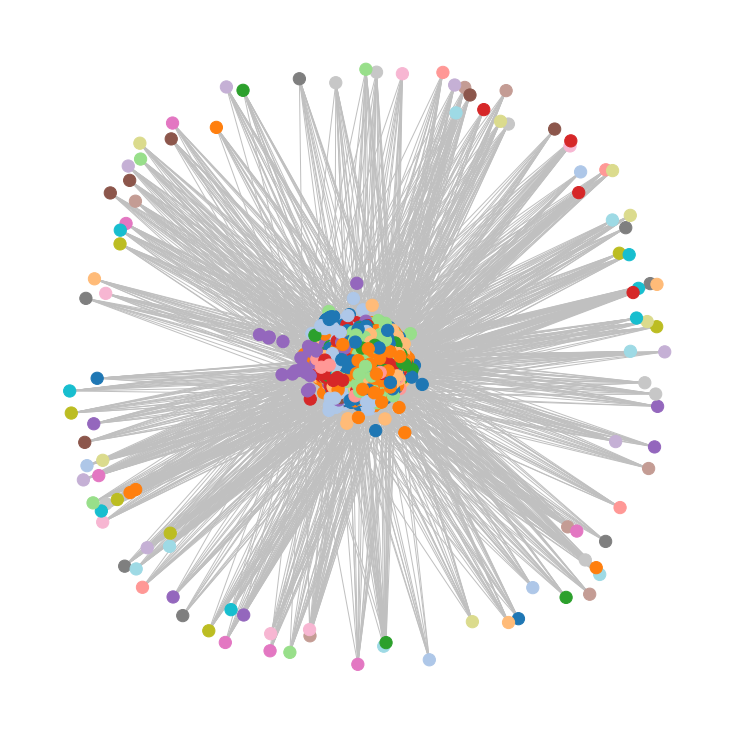

In [163]:
# Takes some time for larger graphs
import matplotlib.pyplot as plt
pos = nx.spring_layout(G, dim=2)
community_id = [partition[node] for node in G.nodes()]
fig = plt.figure(figsize=(10,10))
nx.draw(G, pos, edge_color = ['silver']*len(G.edges()), cmap=plt.cm.tab20,
        node_color=community_id, node_size=150)

In [164]:
title, cluster = [], []
for i in partition.items():
    title.append(i[0])
    cluster.append(i[1])
    
frame_clust = pd.DataFrame([pd.Series(title), pd.Series(cluster)]).transpose()
frame_clust.columns = ['Title', 'Cluster']

In [179]:
frame_clust.head()

,Title,Cluster
0,,0
1,non scale job cluster,3
2,arr workspace connectivity storage account...,2
3,high concurrency cluster prod terminate w...,3
4,read json csv file bitbucket repository ...,35


In [180]:
len(frame_clust.Cluster.value_counts())

138

In [185]:
#avd = single_matrix[single_matrix['source'] ==           'avd'].drop_duplicates()
frames = [frame_clust, data]
result = pd.concat(frames)
result.head()
grouped_mat = result.groupby('Cluster').agg({'Title': 'count'})
grouped_mat.rename(
    columns=({'Title':'title_count','Cluster':'cluster'}), 
    inplace=True
)
grouped_mat = grouped_mat.sort_values(by = ['title_count'])

grouped_mat.head()

,title_count
Cluster,
0,1
100,1
99,1
98,1
97,1


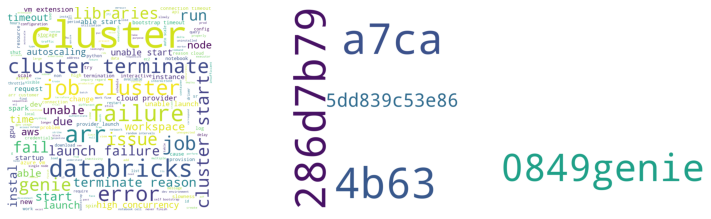

In [182]:
from wordcloud import WordCloud
fig, ax = plt.subplots(1, 3, figsize=(12.5,6.5))
clusters = [3, 39, 38] #lowest activity groups
# clusters = [43, 28, 7] #highest activity groups
for cluster, col in zip(clusters, [0, 1, 2]):
    corpus = (' ').join(result['Title'][result['Cluster'] == cluster])      
    ax[col].imshow(WordCloud(width = 800,
                             height = 800,
                             background_color ='white', 
                             min_font_size = 10).generate(corpus))
    ax[col].axis("off")
plt.show()
